In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt, resample
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time
import platform

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, BatchNormalization
from keras.layers.core import Permute, Reshape
from keras import backend as K

C:\Users\andre\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
if platform.system() == 'Windows':
    if platform.release() == '10':
        path = r'D:\CIS-PD Study\Subjects' #Windows remote path
        folder_path = r'D:\CIS-PD Study' #generic Windows repo path
        dict_path = 'D:\CIS-PD Study\Data_dict'
        scores_path = r'D:\CIS-PD Study\Scores' #remote repo
        features_path = r'D:\CIS-PD Study\FeatureMatrix' #remote repo
        
    elif platform.release() == '7':
        path = r'X:\CIS-PD Study\Subjects'
        folder_path = r'X:\CIS-PD Study'
#         dict_path = r'C:\Users\adai\Documents\Data_dict'
        dict_path = r'X:\CIS-PD Study\Data_dict'
        scores_path = r'X:\CIS-PD Study\Scores'
        features_path = r'X:\CIS-PD Study\FeatureMatrix'

In [4]:
mot_scores = pd.read_excel(os.path.join(scores_path,'Scores.xls'))

In [5]:
mot_scores.head()

,site,subject,visit,crf#,data collected,date of assessment,what is the participant’s state,on which hand is the subject wearing the apple watch,was the device shaken 5 times up and down prior to beginning the assessment,patient’s apple watch clock time when the stop watch is turned on,...,folding towels tremor left upper limb,folding towels tremor right upper limb,was sitting assessed,sitting start time,sitting end time,sitting dyskinesia left upper limb,sitting dyskinesia right upper limb,sitting tremor left upper limb,sitting tremor upper right limb,general comments
0,"Northwestern Memorial Hospital, Chicago, IL",1004,2 Weeks: Time 0,438,Yes,2017-07-07,Off,Right,Yes,0.360185,...,1.0,1.0,Yes,0.010648,0.010995,0.0,0.0,0.0,0.0,NaN
1,"Northwestern Memorial Hospital, Chicago, IL",1004,2 Weeks: Time 30,447,Yes,2017-07-07,Off,Right,Yes,0.390961,...,0.0,0.0,Yes,0.008252,0.008600,0.0,0.0,0.0,0.0,NaN
2,"Northwestern Memorial Hospital, Chicago, IL",1004,2 Weeks: Time 60,449,Yes,2017-07-07,On,Right,Yes,0.419329,...,0.0,0.0,Yes,0.007060,0.007407,0.0,1.0,0.0,0.0,NaN
3,"Northwestern Memorial Hospital, Chicago, IL",1004,2 Weeks: Time 90,452,Yes,2017-07-07,On,Right,Yes,0.441146,...,0.0,0.0,Yes,0.007384,0.007731,0.0,0.0,0.0,0.0,NaN
4,"Northwestern Memorial Hospital, Chicago, IL",1004,2 Weeks: Time 120,454,Yes,2017-07-07,On,Right,Yes,0.459236,...,0.0,0.0,Yes,0.006435,0.006782,0.0,0.0,0.0,0.0,NaN


In [6]:
task_scores = ['walking','walking while counting','finger to nose','alternating','sit to stand',
               'drawing on a paper','typing on a computer keyboard','assembling nuts and bolts',
               'taking a glass of water and drinking','organizing sheets in a folder','folding towels',
               'standing','sitting']

In [7]:
d = os.listdir(dict_path)
fnames = [filename[:4] for filename in d if filename.startswith('1')]

fluc = ['1038','1047','1052','1053','1054','1055','1056']

nonfluc = [names for names in fnames if names not in fluc]

full = fnames
print('full: %s\n'%full)
print('fluctuators: %s\n'%fluc)
print('non fluctuators: %s\n'%nonfluc)

full: ['1004', '1016', '1018', '1019', '1020', '1024', '1029', '1030', '1032', '1038', '1044', '1046', '1047', '1049', '1051', '1052', '1053', '1054', '1055', '1056']

fluctuators: ['1038', '1047', '1052', '1053', '1054', '1055', '1056']

non fluctuators: ['1004', '1016', '1018', '1019', '1020', '1024', '1029', '1030', '1032', '1044', '1046', '1049', '1051']



In [8]:
def aggregate_scores(task_scores):
    scores = pd.DataFrame()

    fnames = full;
#     fnames = fluc;
#     fnames = nonfluc;
    

    for subjnames in fnames:
        for task in task_scores:
            for side in ['right','left']:
                ts = task;
                subj = int(subjnames);

                if (task.find('alternating') > -1) | (task.find('finger to nose') > -1):
                    task=ts+ ' ' + side

                subj_score = mot_scores.loc[mot_scores['subject']==subj,['subject','visit',
                                            task+ ' ' + 'bradykinesia ' + side + ' upper limb',
                                            task+ ' ' + 'tremor ' + side + ' upper limb']]

                subj_score = subj_score.rename(index=str,
                                               columns={subj_score.columns[2]:'Bradykinesia',subj_score.columns[3]:'Tremor'})

                scores = pd.concat([scores,subj_score])

    return scores

In [9]:
scores = aggregate_scores(task_scores)
scores.head()

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
C:\Users\andre\Anaconda3\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,subject,visit,Bradykinesia,Tremor
0,1004,2 Weeks: Time 0,0.0,0.0
1,1004,2 Weeks: Time 30,1.0,0.0
2,1004,2 Weeks: Time 60,0.0,0.0
3,1004,2 Weeks: Time 90,0.0,0.0
4,1004,2 Weeks: Time 120,1.0,0.0


In [46]:
subList = scores['subject'].unique()

for subs in subList:
    df = scores.loc[scores['subject'] == subs]['Tremor']
    df = df[~np.isnan(df)]
    pos = np.size(df[df!=0])
    neg = np.size(df[df==0])
    print('Subject: %d'%subs)
    print('# Positive Tremor instances: %d'%pos)
    print('# Negative Tremor instances: %d\n'%neg)

Subject: 1004
# Positive Tremor instances: 11
# Negative Tremor instances: 150

Subject: 1016
# Positive Tremor instances: 64
# Negative Tremor instances: 95

Subject: 1018
# Positive Tremor instances: 7
# Negative Tremor instances: 154

Subject: 1019
# Positive Tremor instances: 3
# Negative Tremor instances: 158

Subject: 1020
# Positive Tremor instances: 5
# Negative Tremor instances: 18

Subject: 1024
# Positive Tremor instances: 29
# Negative Tremor instances: 128

Subject: 1029
# Positive Tremor instances: 57
# Negative Tremor instances: 104

Subject: 1030
# Positive Tremor instances: 5
# Negative Tremor instances: 156

Subject: 1032
# Positive Tremor instances: 5
# Negative Tremor instances: 156

Subject: 1038
# Positive Tremor instances: 84
# Negative Tremor instances: 77

Subject: 1044
# Positive Tremor instances: 0
# Negative Tremor instances: 161

Subject: 1046
# Positive Tremor instances: 28
# Negative Tremor instances: 133

Subject: 1047
# Positive Tremor instances: 2
# Ne

In [22]:
structured = ['finger to nose','alternating']
functional = ['walking','walking while counting','sit to stand','standing','sitting']
finemot = ['drawing on a paper','typing on a computer keyboard','assembling nuts and bolts']
grosmot = ['taking a glass of water and drinking','organizing sheets in a folder','folding towels']

In [23]:
structured_scores = aggregate_scores(structured)
functional_scores = aggregate_scores(functional)
finemot_scores = aggregate_scores(finemot)
grosmot_scores = aggregate_scores(grosmot)

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
C:\Users\andre\Anaconda3\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [24]:
np.size(structured_scores.Bradykinesia[structured_scores.Bradykinesia > 0])

135

## Bradykinesia Instances

bradykinesia structured: 135
no bradykinesia structured: 121
bradykinesia functional: 242
no bradykinesia functional: 266
bradykinesia fine motor: 384
no bradykinesia fine motor: 384
bradykinesia gross motor: 320
no bradykinesia gross motor: 448


Structured Tasks: ['finger to nose', 'alternating']
Functional Tasks: ['walking', 'walking while counting', 'sit to stand', 'standing', 'sitting']
Fine Motor Tasks: ['drawing on a paper', 'typing on a computer keyboard', 'assembling nuts and bolts']
Gross Motor Tasks: ['taking a glass of water and drinking', 'organizing sheets in a folder', 'folding towels']


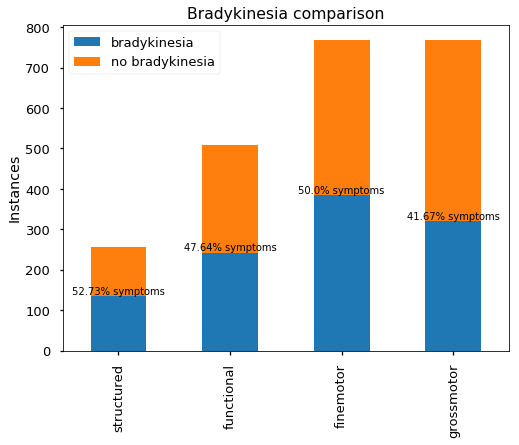

In [55]:
struc_brady = len(structured_scores.Bradykinesia[structured_scores.Bradykinesia > 0])
print('bradykinesia structured: %d'%struc_brady)
struc_nobrady = len(structured_scores.Bradykinesia[structured_scores.Bradykinesia == 0])
print('no bradykinesia structured: %d'%struc_nobrady)

func_brady = len(functional_scores.Bradykinesia[functional_scores.Bradykinesia > 0])
print('bradykinesia functional: %d'%func_brady)
func_nobrady = len(functional_scores.Bradykinesia[functional_scores.Bradykinesia == 0])
print('no bradykinesia functional: %d'%func_nobrady)

finemot_brady = len(finemot_scores.Bradykinesia[finemot_scores.Bradykinesia > 0])
print('bradykinesia fine motor: %d'%finemot_brady)
finemot_nobrady = len(finemot_scores.Bradykinesia[finemot_scores.Bradykinesia == 0])
print('no bradykinesia fine motor: %d'%finemot_nobrady)

grosmot_brady = len(grosmot_scores.Bradykinesia[grosmot_scores.Bradykinesia > 0])
print('bradykinesia gross motor: %d'%grosmot_brady)
grosmot_nobrady = len(grosmot_scores.Bradykinesia[grosmot_scores.Bradykinesia == 0])
print('no bradykinesia gross motor: %d'%grosmot_nobrady)

print('\n')

print('Structured Tasks: %s'%structured)
print('Functional Tasks: %s'%functional)
print('Fine Motor Tasks: %s'%finemot)
print('Gross Motor Tasks: %s'%grosmot)

symptom = pd.DataFrame(data=[struc_brady, func_brady, finemot_brady, grosmot_brady], index=['structured','functional','finemotor','grossmotor'],columns=['bradykinesia']);
symptom = pd.concat([symptom, pd.DataFrame(data=[struc_nobrady, func_nobrady, finemot_nobrady, grosmot_nobrady], index=['structured','functional','finemotor','grossmotor'],
                                          columns=['no bradykinesia'])],axis=1);

ind = np.arange(2); width = 0.35;

ax = symptom.plot.bar(stacked=True,figsize=(8,6))
rect = ax.patches

label = 100*np.around([(struc_brady / (struc_brady + struc_nobrady)),
                  (func_brady / (func_brady + func_nobrady)),
                  (finemot_brady / (finemot_brady + finemot_nobrady)),
                  (grosmot_brady / (grosmot_brady + grosmot_nobrady))],
                  decimals=4)


for rect, label in zip(rect,label):
    label = str(label) + '% symptoms'
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')
    
plt.title('Bradykinesia comparison')
plt.ylabel('Instances')
plt.savefig('Bradykinesia score comparison.png',bbox_inches='tight')
plt.show()

## Tremor Instances

tremor structured: 73
no tremor structured: 183
tremor functional: 139
no tremor functional: 1006
tremor fine motor: 165
no tremor fine motor: 601
tremor gross motor: 203
no tremor gross motor: 565


Structured Tasks: ['finger to nose', 'alternating']
Functional Tasks: ['walking', 'walking while counting', 'sit to stand', 'standing', 'sitting']
Fine Motor Tasks: ['drawing on a paper', 'typing on a computer keyboard', 'assembling nuts and bolts']
Gross Motor Tasks: ['taking a glass of water and drinking', 'organizing sheets in a folder', 'folding towels']


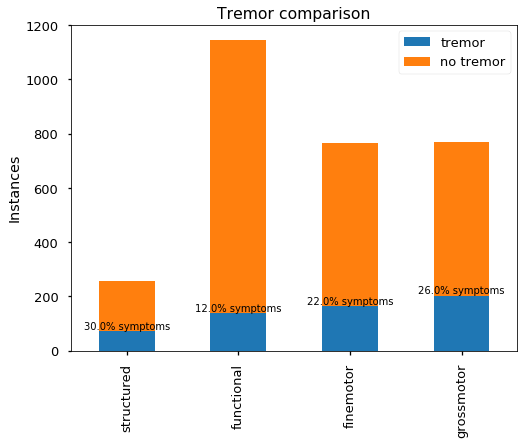

In [54]:
struc_tremor = len(structured_scores.Tremor[structured_scores.Tremor > 0])
print('tremor structured: %d'%struc_tremor)
struc_notremor = len(structured_scores.Tremor[structured_scores.Tremor == 0])
print('no tremor structured: %d'%struc_notremor)

func_tremor = len(functional_scores.Tremor[functional_scores.Tremor > 0])
print('tremor functional: %d'%func_tremor)
func_notremor = len(functional_scores.Tremor[functional_scores.Tremor == 0])
print('no tremor functional: %d'%func_notremor)

finemot_tremor = len(finemot_scores.Tremor[finemot_scores.Tremor > 0])
print('tremor fine motor: %d'%finemot_tremor)
finemot_notremor = len(finemot_scores.Tremor[finemot_scores.Tremor == 0])
print('no tremor fine motor: %d'%finemot_notremor)

grosmot_tremor = len(grosmot_scores.Tremor[grosmot_scores.Tremor > 0])
print('tremor gross motor: %d'%grosmot_tremor)
grosmot_notremor = len(grosmot_scores.Tremor[grosmot_scores.Tremor == 0])
print('no tremor gross motor: %d'%grosmot_notremor)

print('\n')

print('Structured Tasks: %s'%structured)
print('Functional Tasks: %s'%functional)
print('Fine Motor Tasks: %s'%finemot)
print('Gross Motor Tasks: %s'%grosmot)

symptom = pd.DataFrame(data=[struc_tremor, func_tremor, finemot_tremor, grosmot_tremor], index=['structured','functional','finemotor','grossmotor'],columns=['tremor']);
symptom = pd.concat([symptom, pd.DataFrame(data=[struc_notremor, func_notremor, finemot_notremor, grosmot_notremor], index=['structured','functional','finemotor','grossmotor'],
                                          columns=['no tremor'])],axis=1);

ind = np.arange(2); width = 0.35;

ax = symptom.plot.bar(stacked=True,figsize=(8,6))
rect = ax.patches

label = 100*np.around([(struc_tremor / (struc_tremor + struc_notremor))+0.01,
                  (func_tremor / (func_tremor + func_notremor)),
                  (finemot_tremor / (finemot_tremor + finemot_notremor)),
                  (grosmot_tremor / (grosmot_tremor + grosmot_notremor))],
                  decimals=2)


for rect, label in zip(rect,label):
    label = str(label) + '% symptoms'
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')
    
plt.title('Tremor comparison')
plt.ylabel('Instances')
plt.savefig('Tremor score comparison.png',bbox_inches='tight')
plt.show()

## Try different activities for tremor

In [201]:
structured = ['finger to nose','alternating']
functional = ['walking','walking while counting','sit to stand','standing','sitting',
              'drawing on a paper','typing on a computer keyboard','assembling nuts and bolts',
              'taking a glass of water and drinking','organizing sheets in a folder','folding towels']

structured_scores = aggregate_scores(structured)
functional_scores = aggregate_scores(functional)

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
C:\Users\andre\Anaconda3\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


tremor structured: 138
no tremor structured: 118
tremor functional: 274
no tremor functional: 1131


Structured Tasks: ['finger to nose', 'alternating']
Functional Tasks: ['walking', 'walking while counting', 'sit to stand', 'standing', 'sitting', 'drawing on a paper', 'typing on a computer keyboard', 'assembling nuts and bolts', 'taking a glass of water and drinking', 'organizing sheets in a folder', 'folding towels']


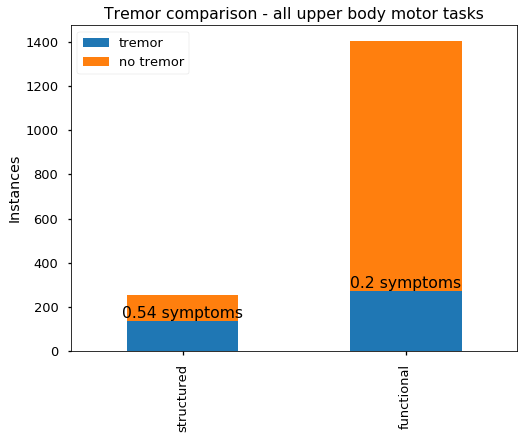

In [202]:
struc_tremor = len(structured_scores.Tremor[structured_scores.Tremor > 0])
print('tremor structured: %d'%struc_tremor)
struc_notremor = len(structured_scores.Tremor[structured_scores.Tremor == 0])
print('no tremor structured: %d'%struc_notremor)

func_tremor = len(functional_scores.Tremor[functional_scores.Tremor > 0])
print('tremor functional: %d'%func_tremor)
func_notremor = len(functional_scores.Tremor[functional_scores.Tremor == 0])
print('no tremor functional: %d'%func_notremor)

print('\n')

print('Structured Tasks: %s'%structured)
print('Functional Tasks: %s'%functional)

symptom = pd.DataFrame(data=[struc_tremor, func_tremor], index=['structured','functional'],columns=['tremor']);
symptom = pd.concat([symptom, pd.DataFrame(data=[struc_notremor, func_notremor], index=['structured','functional'],
                                          columns=['no tremor'])],axis=1);

ind = np.arange(2); width = 0.35;

ax = symptom.plot.bar(stacked=True,figsize=(8,6))
rect = ax.patches

label = np.around([(struc_tremor / (struc_tremor + struc_notremor)),
                  (func_tremor / (func_tremor + func_notremor))],
                  decimals=2)


for rect, label in zip(rect,label):
    label = str(label) + ' symptoms'
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')
    
plt.title('Tremor comparison - all upper body motor tasks')
plt.ylabel('Instances')

plt.show()

In [203]:
structured = ['finger to nose','alternating']
functional = ['sit to stand','standing','sitting',
              'drawing on a paper','typing on a computer keyboard','assembling nuts and bolts',
              'taking a glass of water and drinking','organizing sheets in a folder','folding towels']

structured_scores = aggregate_scores(structured)
functional_scores = aggregate_scores(functional)

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
C:\Users\andre\Anaconda3\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


tremor structured: 138
no tremor structured: 118
tremor functional: 250
no tremor functional: 901


Structured Tasks: ['finger to nose', 'alternating']
Functional Tasks: ['sit to stand', 'standing', 'sitting', 'drawing on a paper', 'typing on a computer keyboard', 'assembling nuts and bolts', 'taking a glass of water and drinking', 'organizing sheets in a folder', 'folding towels']


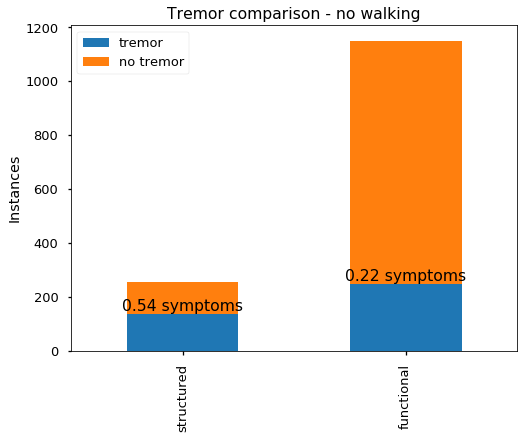

In [204]:
struc_tremor = len(structured_scores.Tremor[structured_scores.Tremor > 0])
print('tremor structured: %d'%struc_tremor)
struc_notremor = len(structured_scores.Tremor[structured_scores.Tremor == 0])
print('no tremor structured: %d'%struc_notremor)

func_tremor = len(functional_scores.Tremor[functional_scores.Tremor > 0])
print('tremor functional: %d'%func_tremor)
func_notremor = len(functional_scores.Tremor[functional_scores.Tremor == 0])
print('no tremor functional: %d'%func_notremor)

print('\n')

print('Structured Tasks: %s'%structured)
print('Functional Tasks: %s'%functional)

symptom = pd.DataFrame(data=[struc_tremor, func_tremor], index=['structured','functional'],columns=['tremor']);
symptom = pd.concat([symptom, pd.DataFrame(data=[struc_notremor, func_notremor], index=['structured','functional'],
                                          columns=['no tremor'])],axis=1);

ind = np.arange(2); width = 0.35;

ax = symptom.plot.bar(stacked=True,figsize=(8,6))
rect = ax.patches

label = np.around([(struc_tremor / (struc_tremor + struc_notremor)),
                  (func_tremor / (func_tremor + func_notremor))],
                  decimals=2)


for rect, label in zip(rect,label):
    label = str(label) + ' symptoms'
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')
    
plt.title('Tremor comparison - no walking')
plt.ylabel('Instances')

plt.show()

In [205]:
structured = ['finger to nose','alternating']
functional = ['drawing on a paper','typing on a computer keyboard','assembling nuts and bolts',
              'taking a glass of water and drinking','organizing sheets in a folder','folding towels']

structured_scores = aggregate_scores(structured)
functional_scores = aggregate_scores(functional)

tremor structured: 138
no tremor structured: 118
tremor functional: 207
no tremor functional: 560


Structured Tasks: ['finger to nose', 'alternating']
Functional Tasks: ['drawing on a paper', 'typing on a computer keyboard', 'assembling nuts and bolts', 'taking a glass of water and drinking', 'organizing sheets in a folder', 'folding towels']


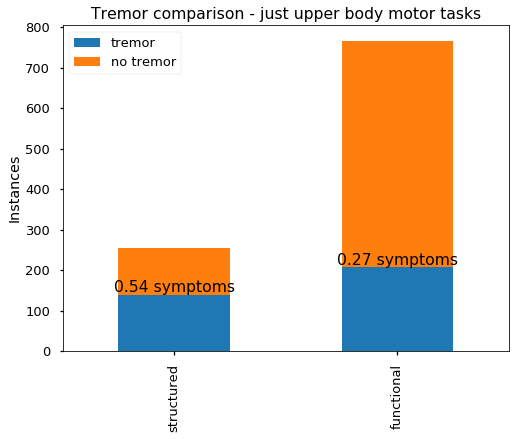

In [206]:
struc_tremor = len(structured_scores.Tremor[structured_scores.Tremor > 0])
print('tremor structured: %d'%struc_tremor)
struc_notremor = len(structured_scores.Tremor[structured_scores.Tremor == 0])
print('no tremor structured: %d'%struc_notremor)

func_tremor = len(functional_scores.Tremor[functional_scores.Tremor > 0])
print('tremor functional: %d'%func_tremor)
func_notremor = len(functional_scores.Tremor[functional_scores.Tremor == 0])
print('no tremor functional: %d'%func_notremor)

print('\n')

print('Structured Tasks: %s'%structured)
print('Functional Tasks: %s'%functional)

symptom = pd.DataFrame(data=[struc_tremor, func_tremor], index=['structured','functional'],columns=['tremor']);
symptom = pd.concat([symptom, pd.DataFrame(data=[struc_notremor, func_notremor], index=['structured','functional'],
                                          columns=['no tremor'])],axis=1);

ind = np.arange(2); width = 0.35;

ax = symptom.plot.bar(stacked=True,figsize=(8,6))
rect = ax.patches

label = np.around([(struc_tremor / (struc_tremor + struc_notremor)),
                  (func_tremor / (func_tremor + func_notremor))],
                  decimals=2)


for rect, label in zip(rect,label):
    label = str(label) + ' symptoms'
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')
    
plt.title('Tremor comparison - just upper body motor tasks')
plt.ylabel('Instances')

plt.show()

In [207]:
structured = ['finger to nose','alternating']
functional = ['drawing on a paper','typing on a computer keyboard','assembling nuts and bolts']

structured_scores = aggregate_scores(structured)
functional_scores = aggregate_scores(functional)

tremor structured: 138
no tremor structured: 118
tremor functional: 89
no tremor functional: 294


Structured Tasks: ['finger to nose', 'alternating']
Functional Tasks: ['drawing on a paper', 'typing on a computer keyboard', 'assembling nuts and bolts']


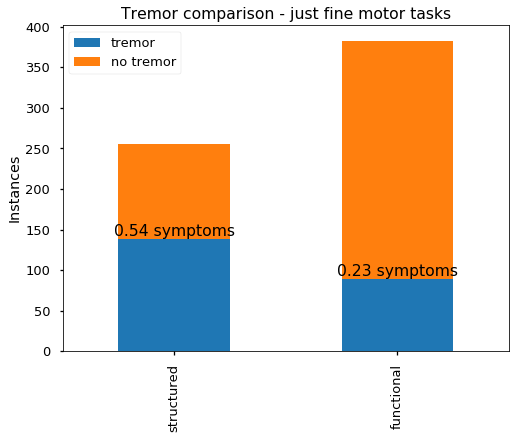

In [208]:
struc_tremor = len(structured_scores.Tremor[structured_scores.Tremor > 0])
print('tremor structured: %d'%struc_tremor)
struc_notremor = len(structured_scores.Tremor[structured_scores.Tremor == 0])
print('no tremor structured: %d'%struc_notremor)

func_tremor = len(functional_scores.Tremor[functional_scores.Tremor > 0])
print('tremor functional: %d'%func_tremor)
func_notremor = len(functional_scores.Tremor[functional_scores.Tremor == 0])
print('no tremor functional: %d'%func_notremor)

print('\n')

print('Structured Tasks: %s'%structured)
print('Functional Tasks: %s'%functional)

symptom = pd.DataFrame(data=[struc_tremor, func_tremor], index=['structured','functional'],columns=['tremor']);
symptom = pd.concat([symptom, pd.DataFrame(data=[struc_notremor, func_notremor], index=['structured','functional'],
                                          columns=['no tremor'])],axis=1);

ind = np.arange(2); width = 0.35;

ax = symptom.plot.bar(stacked=True,figsize=(8,6))
rect = ax.patches

label = np.around([(struc_tremor / (struc_tremor + struc_notremor)),
                  (func_tremor / (func_tremor + func_notremor))],
                  decimals=2)


for rect, label in zip(rect,label):
    label = str(label) + ' symptoms'
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')
    
plt.title('Tremor comparison - just fine motor tasks')
plt.ylabel('Instances')

plt.show()

In [209]:
structured = ['finger to nose','alternating']
functional = ['taking a glass of water and drinking','organizing sheets in a folder','folding towels']

structured_scores = aggregate_scores(structured)
functional_scores = aggregate_scores(functional)

tremor structured: 138
no tremor structured: 118
tremor functional: 118
no tremor functional: 266


Structured Tasks: ['finger to nose', 'alternating']
Functional Tasks: ['taking a glass of water and drinking', 'organizing sheets in a folder', 'folding towels']


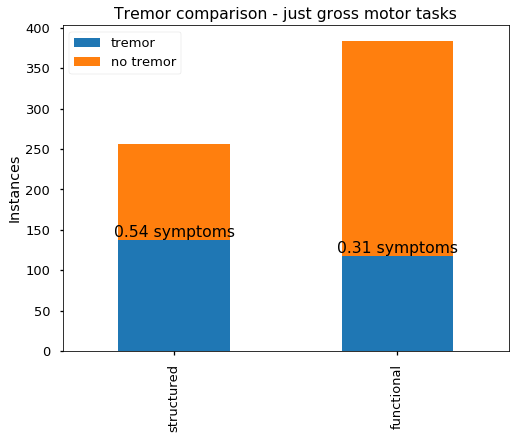

In [210]:
struc_tremor = len(structured_scores.Tremor[structured_scores.Tremor > 0])
print('tremor structured: %d'%struc_tremor)
struc_notremor = len(structured_scores.Tremor[structured_scores.Tremor == 0])
print('no tremor structured: %d'%struc_notremor)

func_tremor = len(functional_scores.Tremor[functional_scores.Tremor > 0])
print('tremor functional: %d'%func_tremor)
func_notremor = len(functional_scores.Tremor[functional_scores.Tremor == 0])
print('no tremor functional: %d'%func_notremor)

print('\n')

print('Structured Tasks: %s'%structured)
print('Functional Tasks: %s'%functional)

symptom = pd.DataFrame(data=[struc_tremor, func_tremor], index=['structured','functional'],columns=['tremor']);
symptom = pd.concat([symptom, pd.DataFrame(data=[struc_notremor, func_notremor], index=['structured','functional'],
                                          columns=['no tremor'])],axis=1);

ind = np.arange(2); width = 0.35;

ax = symptom.plot.bar(stacked=True,figsize=(8,6))
rect = ax.patches

label = np.around([(struc_tremor / (struc_tremor + struc_notremor)),
                  (func_tremor / (func_tremor + func_notremor))],
                  decimals=2)


for rect, label in zip(rect,label):
    label = str(label) + ' symptoms'
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')
    
plt.title('Tremor comparison - just gross motor tasks')
plt.ylabel('Instances')

plt.show()

In [211]:
structured = ['finger to nose','alternating']
functional = ['walking','standing','sitting',
              'taking a glass of water and drinking','organizing sheets in a folder','folding towels']

structured_scores = aggregate_scores(structured)
functional_scores = aggregate_scores(functional)

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
C:\Users\andre\Anaconda3\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


tremor structured: 138
no tremor structured: 118
tremor functional: 162
no tremor functional: 606


Structured Tasks: ['finger to nose', 'alternating']
Functional Tasks: ['walking', 'standing', 'sitting', 'taking a glass of water and drinking', 'organizing sheets in a folder', 'folding towels']


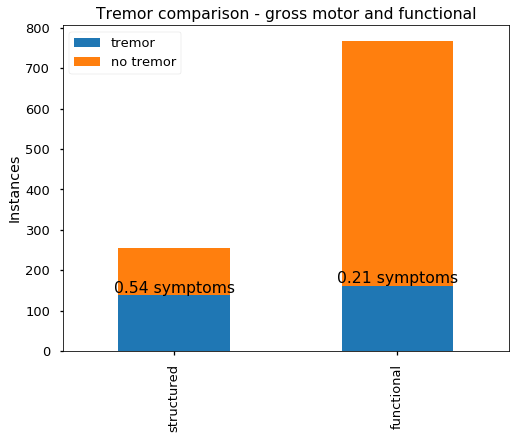

In [212]:
struc_tremor = len(structured_scores.Tremor[structured_scores.Tremor > 0])
print('tremor structured: %d'%struc_tremor)
struc_notremor = len(structured_scores.Tremor[structured_scores.Tremor == 0])
print('no tremor structured: %d'%struc_notremor)

func_tremor = len(functional_scores.Tremor[functional_scores.Tremor > 0])
print('tremor functional: %d'%func_tremor)
func_notremor = len(functional_scores.Tremor[functional_scores.Tremor == 0])
print('no tremor functional: %d'%func_notremor)

print('\n')

print('Structured Tasks: %s'%structured)
print('Functional Tasks: %s'%functional)

symptom = pd.DataFrame(data=[struc_tremor, func_tremor], index=['structured','functional'],columns=['tremor']);
symptom = pd.concat([symptom, pd.DataFrame(data=[struc_notremor, func_notremor], index=['structured','functional'],
                                          columns=['no tremor'])],axis=1);

ind = np.arange(2); width = 0.35;

ax = symptom.plot.bar(stacked=True,figsize=(8,6))
rect = ax.patches

label = np.around([(struc_tremor / (struc_tremor + struc_notremor)),
                  (func_tremor / (func_tremor + func_notremor))],
                  decimals=2)


for rect, label in zip(rect,label):
    label = str(label) + ' symptoms'
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')
    
plt.title('Tremor comparison - gross motor and functional')
plt.ylabel('Instances')

plt.show()

In [213]:
structured = ['finger to nose','alternating']
functional = ['walking while counting','standing','sitting']

structured_scores = aggregate_scores(structured)
functional_scores = aggregate_scores(functional)

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
C:\Users\andre\Anaconda3\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


tremor structured: 138
no tremor structured: 118
tremor functional: 44
no tremor functional: 338


Structured Tasks: ['finger to nose', 'alternating']
Functional Tasks: ['walking while counting', 'standing', 'sitting']


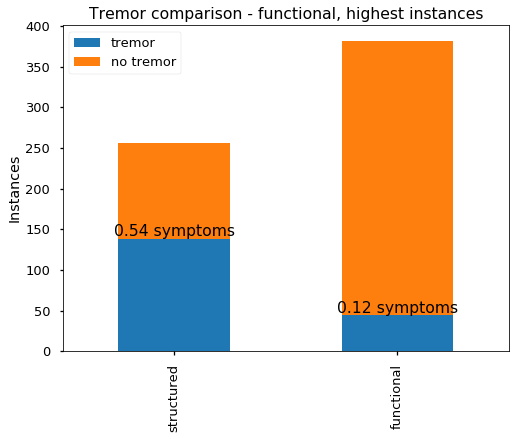

In [215]:
struc_tremor = len(structured_scores.Tremor[structured_scores.Tremor > 0])
print('tremor structured: %d'%struc_tremor)
struc_notremor = len(structured_scores.Tremor[structured_scores.Tremor == 0])
print('no tremor structured: %d'%struc_notremor)

func_tremor = len(functional_scores.Tremor[functional_scores.Tremor > 0])
print('tremor functional: %d'%func_tremor)
func_notremor = len(functional_scores.Tremor[functional_scores.Tremor == 0])
print('no tremor functional: %d'%func_notremor)

print('\n')

print('Structured Tasks: %s'%structured)
print('Functional Tasks: %s'%functional)

symptom = pd.DataFrame(data=[struc_tremor, func_tremor], index=['structured','functional'],columns=['tremor']);
symptom = pd.concat([symptom, pd.DataFrame(data=[struc_notremor, func_notremor], index=['structured','functional'],
                                          columns=['no tremor'])],axis=1);

ind = np.arange(2); width = 0.35;

ax = symptom.plot.bar(stacked=True,figsize=(8,6))
rect = ax.patches

label = np.around([(struc_tremor / (struc_tremor + struc_notremor)),
                  (func_tremor / (func_tremor + func_notremor))],
                  decimals=2)


for rect, label in zip(rect,label):
    label = str(label) + ' symptoms'
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')
    
plt.title('Tremor comparison - functional, highest instances')
plt.ylabel('Instances')

plt.show()

In [178]:
Data = pd.read_csv(os.path.join(features_path,'Data_New.csv')) #only HP filter
print(Data.shape)
Data.head(2)

(43002, 44)


,Unnamed: 0,Subject,Visit,Task,Location,Bradykinesia,Tremor,RMSX,RMSY,RMSZ,...,PSD_std,PSD_skew,PSD_kur,jerk_mean,jerk_std,jerk_skew,jerk_kur,Sen_X,Sen_Y,Sen_Z
0,0,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.007757,0.010663,0.006639,...,0.001943,3.019358,8.685826,0.000318,0.039815,-0.184625,12.745926,0.632860,0.662610,0.612830
1,1,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.007055,0.010101,0.006168,...,0.001101,2.173485,4.459587,0.000191,0.025149,-0.091885,0.860041,0.621925,0.629151,0.538592


## Exploring each Subject's score distribution per task

In [38]:
for subs in Data['Subject'].unique():
    temp_d = Data.loc[Data['Subject'] == subs]
    
    BradP=[]; TremorP=[];
    
    for t in temp_d['Task'].unique(): 
        d = temp_d.loc[temp_d['Task']==t]
        BradP.append(sum(d['Bradykinesia'] > 0))
        TremorP.append(sum(d['Tremor'] > 0))
        
#         BradR.append((sum(d['Bradykinesia'] > 0)) / np.shape(d['Bradykinesia'])[0])
#         TremorR.append((sum(d['Tremor'] > 0)) / np.shape(d['Tremor'])[0])

    fig = plt.figure(figsize=(12,6))
    fig.add_subplot(121)
    sns.barplot(x=np.arange(len(BradP)),y=BradP)
    plt.title('Sub %s: Bradykinesia'%subs), plt.xlabel('Task')
    fig.add_subplot(122)
    sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
    plt.title('Sub %s: Tremor'%subs), plt.xlabel('Task')
#     fig.add_subplot(223)
#     sns.barplot(x=np.arange(len(BradR)),y=BradR)
#     plt.title('Bradykinesia Ratio per task'), plt.xlabel('Task')
#     fig.add_subplot(224)
#     sns.barplot(x=np.arange(len(TremorR)),y=TremorR)
#     plt.title('Tremor Ratio per task'), plt.xlabel('Task')

NameError: name 'Data' is not defined

In [21]:
x = BradP.sort(reverse=True)
print(BradP)

[312, 224, 202, 176, 164, 115, 106, 95, 86, 0, 0]
